#Mount Google Drive

In [1]:
#Mount the gdrive to access the data file
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


#Required Packages

In [1]:
#Packages for navigating folder and file structure
import os
import gc
import shutil 
import random

#Packages for reading and processing data
import pandas as pd
import numpy as np

#Pytorch packages for deep learning model construction
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

#Packages for visualizations
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

#Dataset Loading

In [2]:
#Unzip the dataset from the gdrive and place it in /content/train/
!unzip -q /content/gdrive/MyDrive/train.zip

#Function to read a csv file
def read_csv(data, events):
    #Read data csv
    x = pd.read_csv(data)
    #Read events csv
    y = pd.read_csv(events)
    id = '_'.join(x.iloc[0, 0].split('_')[:-1])
    #Get values from data frames
    x = x.iloc[:,1:].values
    y = y.iloc[:,1:].values
    #Return the values
    return x, y

#Total data files 192
selected_files = 96

#Variables to store features and labels
trainset = []
gt = []

#Iterate over each file name and read corresponding data
for filename in tqdm(sorted(os.listdir('./train'))[:selected_files]):
    if 'data' in filename:
        #Get data file
        data_file_name = os.path.join('./train', filename)
        id = filename.split('.')[0]
        #Get events file
        events_file_name = os.path.join('./train', '_'.join(id.split('_')[:-1]) + '_events.csv')
        #Read data from files
        x, y = read_csv(data_file_name, events_file_name)
        #Store the loaded data to lists
        trainset.append(x.T.astype(np.float32))
        gt.append(y.T.astype(np.float32))

  0%|          | 0/96 [00:00<?, ?it/s]

#Exploratory Data Analysis

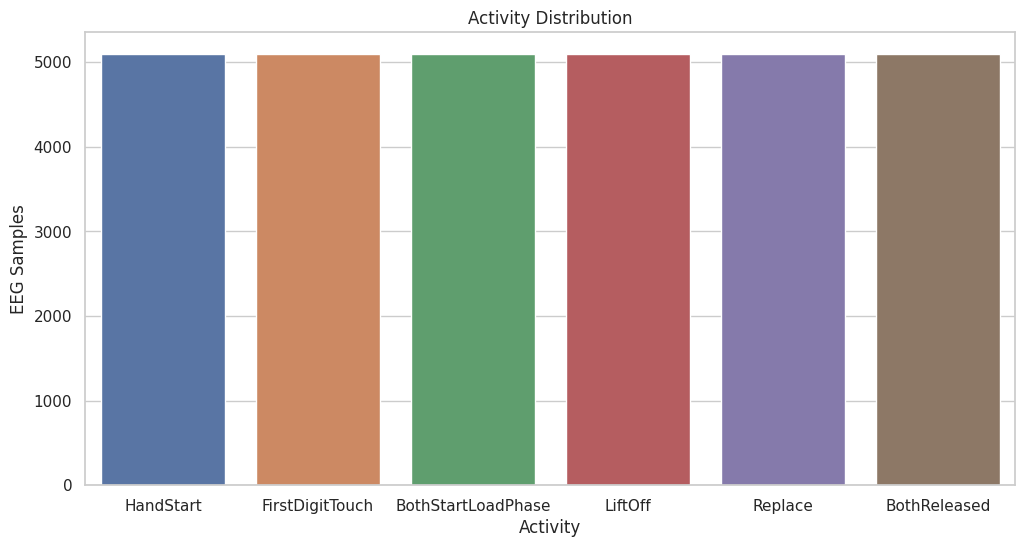

In [3]:
#Activity labels
labels = ['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff',
       'Replace', 'BothReleased']

#Pick a file from the dataset for visualization
eeg_plot = pd.DataFrame(trainset[0])
gt_plot = pd.DataFrame(gt[0])

#Plot the occurrence of each activity
plt.figure(figsize=(12,6), dpi=100)
sns.set_theme(style='whitegrid')
sns.barplot(x=labels, y=gt_plot.sum(axis=1));
#Label the plot
plt.xlabel('Activity')
plt.ylabel('EEG Samples')
plt.title("Activity Distribution");

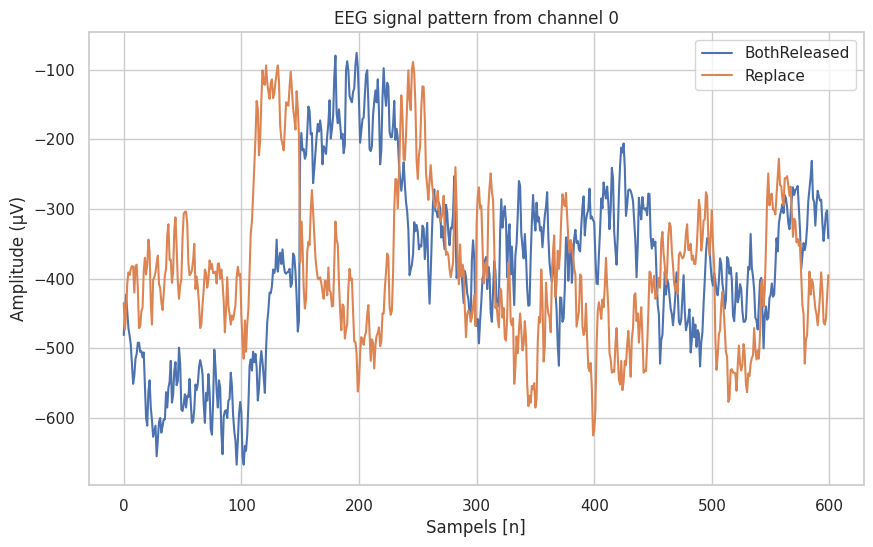

In [4]:
#Pick a channel and the number of samples to plot
channel = 0
plot_samples = 600

#Pick any two activites to plot the pattern for
act_1 = labels.index("BothReleased")
act_2 = labels.index("Replace")

#Plot the pattern for each activity
plt.figure(figsize=(10,6), dpi=100)
plt.plot(range(plot_samples), eeg_plot.T[gt_plot.T.iloc[:,act_1]==1].iloc[:plot_samples].iloc[:,channel])
plt.plot(range(plot_samples), eeg_plot.T[gt_plot.T.iloc[:,act_2]==1].iloc[:plot_samples].iloc[:,channel])
#Label the plot
plt.xlabel("Sampels [n]")
plt.ylabel("Amplitude (µV)")
plt.title("EEG signal pattern from channel "+str(channel));
plt.legend([labels[act_1], labels[act_2]]);

#Data Preprocessing

##Train/Test Split
Pick the last two files for testing and the rest of the files for training the model.

In [5]:
#Test features
valid_dataset = trainset[-2:]
#Labels
valid_gt = gt[-2:]

#Train set features
trainset = trainset[:-2]
#Labels
gt = gt[:-2]

##Discard No-event Chunks

In [6]:
#Set window length
chunk_window = 1000

#Function to find and discard no-event chunks
def resample_data(gt, chunk_size=chunk_window):
    #Count number of chunks
    total_discard_chunks = 0
    #List to store mean values from each chunk
    mean_val = []
    #Discard threshold
    threshold = 0.01
    #Indices of resultant chunks
    index = []
    #Iterate over each activity file
    for i in range(len(gt)):
        #Iterate over data in each file
        for j in range(0, gt[i].shape[1], chunk_size):
            #Calculate and store mean value of the chunk
            mean_val.append(np.mean(gt[i][:, j:min(gt[i].shape[1],j+chunk_size)]))
            #Discard chunks with low events time
            if mean_val[-1] < threshold:  
                total_discard_chunks += 1
            #Store the index of the events with higher activity time
            else:
                index.extend([(i, k) for k in range(j, min(gt[i].shape[1],j+chunk_size))])

    #Plot the mean values of each chunk with dropping threshold
    plt.figure(figsize=(8,6), dpi=100)
    plt.plot([0, len(mean_val)], [threshold, threshold], color='r')
    plt.scatter(range(len(mean_val)), mean_val, s=1)
    #Label the plot
    plt.title("Mean value of each data chunk with dropping threshold")
    plt.xlabel("Chunks")
    plt.ylabel("Mean")
    #Print amount of chunks removed
    print('Total number of chunks discarded: {} chunks'.format(total_discard_chunks))
    print('{}% data'.format(total_discard_chunks/len(mean_val)))
    #Delete unwanted variables to free up memory
    del mean_val
    gc.collect()
    return index

##Pytorch Dataset Class
Since the dataset is huge in size, thus a custom pytorch class is constructed to load the data in batches and perform batch training.

Total number of chunks discarded: 4457 chunks
0.5020840374000225% data
4420000


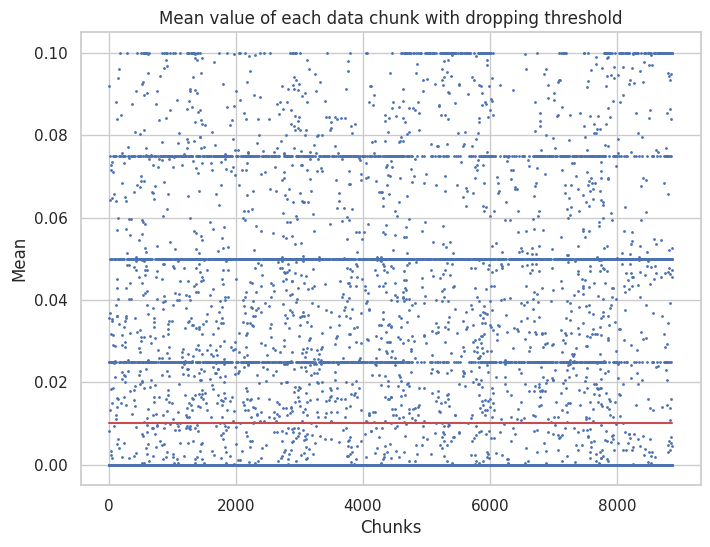

In [7]:
#Provide segment length
segment_len = 1024
#Batch size
batch_size = 1024

class EEGSignalDataset(Dataset):
    def __init__(self, data, gt, train=True):
        #Load the data files
        self.data = data
        self.gt = gt
        self.train = train
        if train:
            #Perform resampling on the training data
            self.index = resample_data(gt)
        else:
            #Set indices for test data
            self.index = [(i, j) for i in range(len(data)) for j in range(data[i].shape[1])]

    #Define the get data item method of the class
    def __getitem__(self, i):
        #Get the data file
        i, j = self.index[i]
        #Segment the samples for each channel to windows
        raw_data, label = self.data[i][:,max(0, j-segment_len+1):j+1], \
                self.gt[i][:,j]

        #Check if padding is needed
        pad = segment_len - raw_data.shape[1]
        if pad:
            #Pad the data segment with zeros
            raw_data = np.pad(raw_data, ((0,0),(pad,0)), 'constant',constant_values=0)
        #Convert the segments and labels to torch tensors
        raw_data, label = torch.from_numpy(raw_data.astype(np.float32)),\
                            torch.from_numpy(label.astype(np.float32))
        #Return features and labels
        return raw_data, label
            
    #Dataset length method
    def __len__(self):
        return len(self.index)

#Create instance of the dataset class providing the data and labels  
dataset = EEGSignalDataset(trainset, gt) 

#Create pytorch data loader providing batch_size
dataloader = DataLoader(dataset, batch_size = batch_size,\
                                       num_workers = 1, shuffle=True)
#Total samples in the data
print(len(dataset))

#Model Design
The model is designed using 1D convolutional neural network. The architecture purely consists of convolutional layers with no fully connected layer which speeds up training and inference time.

In [8]:
class NNet(nn.Module):
    #Initialize the model
    def __init__(self, in_channels=32, out_channels=6):
        super(NNet, self).__init__()
        #Number of hidden units
        self.hidden = 32
        #Model input layers
        self.net = nn.Sequential(
            nn.Conv1d(32, 32, 5, padding=2),
            nn.Conv1d(self.hidden, self.hidden, 16, stride=16),
            nn.LeakyReLU(0.1),
            nn.Conv1d(self.hidden, self.hidden, 7, padding=3),
        )
        #Add six convolutional blocks
        for i in range(6):
            self.net.add_module('conv{}'.format(i), \
                                self.__block(self.hidden, self.hidden))
        #Model output layer
        self.net.add_module('final', nn.Sequential(
            nn.Conv1d(self.hidden, out_channels, 1),
            nn.Sigmoid()
        ))
    #Method for convolutional block
    def __block(self, inchannels, outchannels):
        return nn.Sequential(
            nn.MaxPool1d(2, 2),
            nn.Dropout(p=0.1, inplace=True),
            nn.Conv1d(inchannels, outchannels, 5, padding=2),
            nn.LeakyReLU(0.1),
            nn.Conv1d(outchannels, outchannels, 5, padding=2),
            nn.LeakyReLU(0.1),
        )
    #Model forward pass
    def forward(self, x):
        return self.net(x)

#Create model
nnet = NNet()
#Print model summary
print(nnet)

NNet(
  (net): Sequential(
    (0): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): Conv1d(32, 32, kernel_size=(16,), stride=(16,))
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv1d(32, 32, kernel_size=(7,), stride=(1,), padding=(3,))
    (conv0): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Dropout(p=0.1, inplace=True)
      (2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
      (3): LeakyReLU(negative_slope=0.1)
      (4): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
      (5): LeakyReLU(negative_slope=0.1)
    )
    (conv1): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Dropout(p=0.1, inplace=True)
      (2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
      (3): LeakyReLU(negative_slope=0.1)
      (4): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
      (5): LeakyReLU(neg

#Model Training

In [9]:
#Set number of epochs
epochs = 3
#Check for GPU device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
#Assign device to model
nnet.to(device)
#Binary crossentropy loss function
loss_fnc = nn.BCELoss()
#Model optimizer
adam = optim.Adam(nnet.parameters(), lr=0.002, betas=(0.5, 0.99))
#Lists to store model loss
loss_his, train_loss = [], []
#Set model in training mode
nnet.train()
#Model training loop
for epoch in range(epochs):
    p_bar = tqdm(dataloader)
    #Iterate over batch data
    for i, (x, y) in enumerate(p_bar):
        #Get batch data
        x, y = x.to(device), y.to(device)
        #Forward pass
        pred = nnet(x)
        #Calculate loss
        loss = loss_fnc(pred.squeeze(dim=-1), y)
        #Calculate gradients
        adam.zero_grad()
        loss.backward()
        #Apply gradients to weights
        adam.step()
        #Store model loss
        train_loss.append(loss.item())
        #Print model loss
        p_bar.set_description('[Loss: {}]'.format(train_loss[-1]))
        #Store loss mean over 50 batches
        if i % 50 == 0:
            loss_his.append(np.mean(train_loss))
            train_loss.clear()
    #Print epoch loss
    print('[Epoch {}/{}] [Loss: {}]'.format(epoch+1, 3, loss_his[-1]))

#Save the trained model
torch.save(nnet.state_dict(), 'model.pt')

  0%|          | 0/4317 [00:00<?, ?it/s]

[Epoch 1/3] [Loss: 0.0939000791311264]


  0%|          | 0/4317 [00:00<?, ?it/s]

[Epoch 2/3] [Loss: 0.0843597772717476]


  0%|          | 0/4317 [00:00<?, ?it/s]

[Epoch 3/3] [Loss: 0.0785595566034317]


Text(0.5, 1.0, 'Model loss vs number of batches')

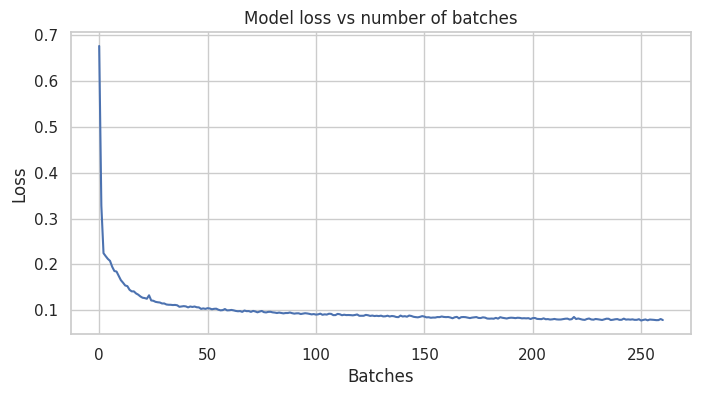

In [10]:
#Plot model loss vs number of batches
plt.figure(figsize=(8,4), dpi=100)
plt.plot(range(len(loss_his)), loss_his, label='loss')
#Label the plot
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.title("Model loss vs number of batches")

#Model Evaluation
##Predictions

In [11]:
#Create a test data instance from the dataset class
testset = EEGSignalDataset(valid_dataset, valid_gt, train=False) 
#Load the data to pytorch dataloader
testloader = DataLoader(testset, batch_size = 1024,\
                                       num_workers = 1, shuffle=False)
#Set the model in evaluation mode
nnet.eval()
#List to store model predictions
y_pred = []
#Set the torch in no gradient mode
with torch.no_grad():
    #Iterate over test batches
    for x, _ in tqdm(testloader):
        #Predictions from the model
        x = x.to(device)
        pred = nnet(x).detach().cpu().numpy()
        #Store prediction probabilities
        y_pred.append(pred)

#Convert prediction probabilities and true labels to numpy array
y_pred = np.concatenate(y_pred, axis=0).squeeze(axis=-1)
valid_gt = np.concatenate(valid_gt, axis=1)
#Convert prediction probabilities to predicted labels
y_pred_lab = y_pred>0.5

  0%|          | 0/225 [00:00<?, ?it/s]

##Confusion matrix and Classification Report

Classification Report for HandStart
              precision    recall  f1-score   support

No-HandStart       0.97      0.99      0.98    219825
   HandStart       0.54      0.33      0.41     10200

    accuracy                           0.96    230025
   macro avg       0.75      0.66      0.69    230025
weighted avg       0.95      0.96      0.95    230025

Classification Report for FirstDigitTouch
                    precision    recall  f1-score   support

No-FirstDigitTouch       0.97      0.99      0.98    219825
   FirstDigitTouch       0.66      0.43      0.52     10200

          accuracy                           0.96    230025
         macro avg       0.82      0.71      0.75    230025
      weighted avg       0.96      0.96      0.96    230025

Classification Report for BothStartLoadPhase
                       precision    recall  f1-score   support

No-BothStartLoadPhase       0.98      0.99      0.98    219825
   BothStartLoadPhase       0.62      0.48      0.54     102

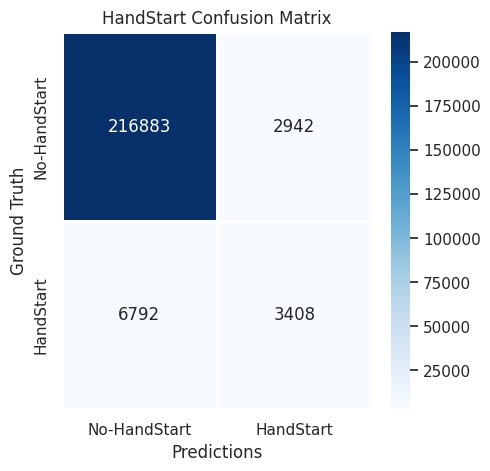

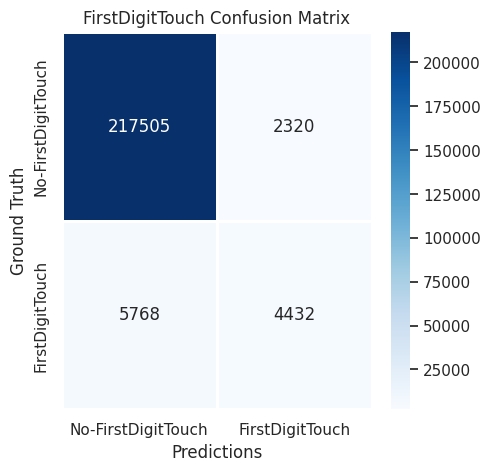

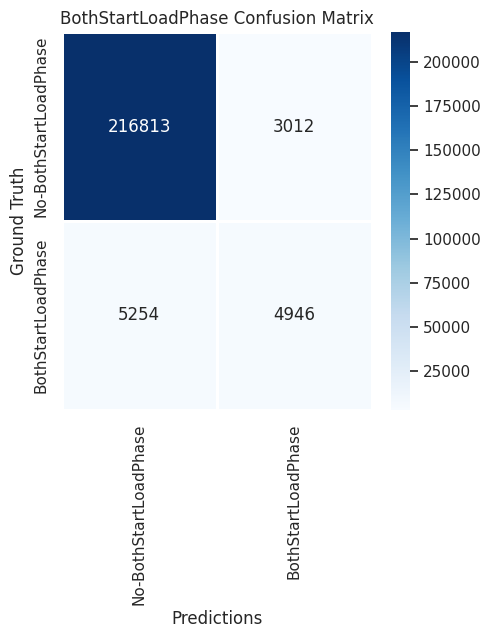

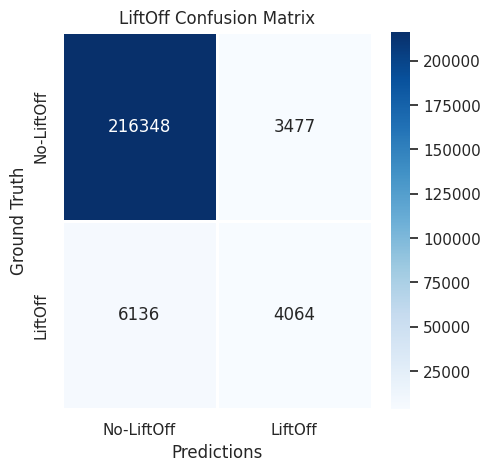

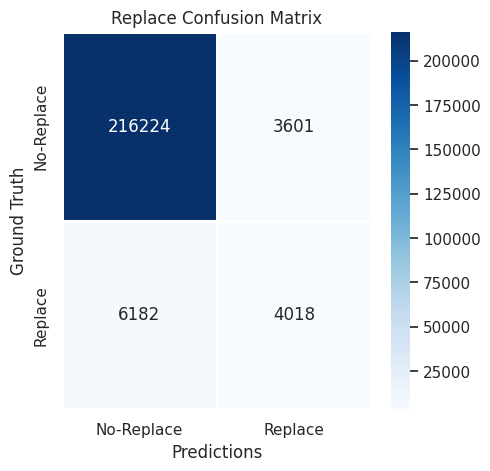

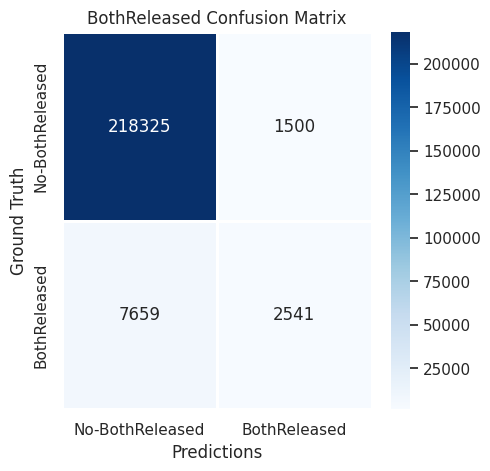

In [12]:
#Function to evaluate performance metrics
def evaluate_metrics(validations, predictions, lab):

  #Calculate and print classification report
  print("Classification Report for "+lab)
  print(metrics.classification_report(validations,predictions, target_names=[l for l in ["No-"+lab, lab]]))

  #Calculate and plot confusion matrix
  matrix = metrics.confusion_matrix(validations, predictions)
  plt.figure(figsize=(5, 5), dpi=100)
  sns.heatmap(matrix,
              cmap='Blues',
              linecolor='white',
              linewidths=1,
              xticklabels=["No-"+lab, lab],
              yticklabels=["No-"+lab, lab],
              annot=True,
              fmt='d')
  #Label the figure
  plt.title(lab+' Confusion Matrix')
  plt.ylabel('Ground Truth')
  plt.xlabel('Predictions')

#Loop over each activity
for i in range(len(labels)):
  #Call evaluation metrics function
  evaluate_metrics(valid_gt.T[:,i],y_pred_lab[:,i], labels[i])

##Receiver Operating Characteristic (ROC) Curves

AUC for combined activities:  0.9098197523802728


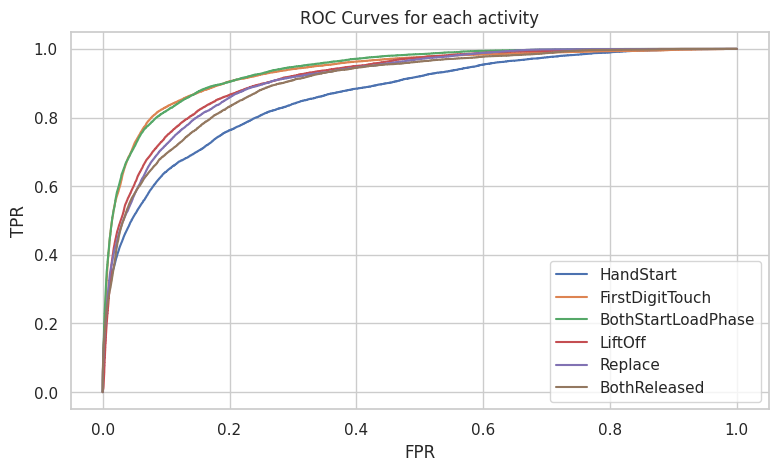

In [16]:
#Plot ROC curves for each activity
def plot_roc(y_true, y_pred):
    #Create empty figure
    plt.figure(figsize=(9,5), dpi=100)
    #Iterate over each activity
    for i, label in enumerate(labels):
        #Calculate tpr and fpr
        fpr, tpr, _ = metrics.roc_curve(y_true[i], y_pred[i])
        #Plot tpr vs fpr
        plt.plot(fpr, tpr)
    #Label the plot
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curves for each activity")
    plt.legend(labels)
    #Print combined area under curve (AUC)
    print('AUC for combined activities: ', metrics.roc_auc_score(valid_gt.T, y_pred.T))

#Call function to plot ROC curves
plot_roc(valid_gt, y_pred.T)

In [31]:
#Save example for later prediction
example_array = x[0].detach().cpu().numpy()
np.savetxt("example_array.csv", example_array, delimiter=",")
#print corresponding label for saved numpy array
print(y[0])

tensor([0., 0., 0., 0., 0., 0.], device='cuda:0')


In [29]:
#Save cpu version of the trained model
torch.save(nnet.to('cpu').state_dict(), 'model2.pt')